# Réseaux de neurones seq2seq sur des séries temporelles

Le plan de match est d'abord d'entraîner un tel réseau sur un tout petit dataset de 2 signaux sinusoidaux simples, puis de tenter de prédire des signaux de plus en plus complexes et de natures un peu différente. 

## Comment utiliser ce notebook au format ".ipynb" ?

Mis à part les versions exportées et le code Python mis à disposition, il est plus intéressant de rouler le code dans un Jupyter notebook pour avoir une approche itérative. Dans un tel notebook, il est possible de rouler chaque cellule une par une (`CTRL+ENTER` ou avec `SHIFT+ENTER`) ou aussi de rouler à nouveau toutes les cellules (cliquer dans les menus sur `Kernel>Restart` pour recommencer, et puis faire `Cell>Run all`). 

Pour installer `jupyter`, il est possible de rouler la commande suivante : "`pip install jupyter`", cependant d'autres méthodes d'installation sont préférables si disponibles (ex: une commande `sudo apt-get`). 
Il se peut qu'il soit requis de faire "`pip install --upgrade pip`" dépendamment de votre installation actuelle. 

Une fois jupyter correctement installé, il est possible d'ouvrir ce notebook en ouvrant le dossier dans lequel il se trouve en ligne de commande, puis en roulant la commande "`jupyter notebook`". Dépendemment de votre installation, il se peut que vous devez plutôt rouler la commande "`ipython notebook`", et cela potentiellement en mettant une lettre majuscule à iPython, tel que la commande "`iPython notebook`".

## Exercices

Note: le dataset change en fonction de l'exercice, et en conséquence, la structure du réseau de neurone changera aussi pour s'adapter, de façon automatique selon la section `Paramètres du réseau de neuronne` plus bas. Il restera au participant de modifier d'avantage ces paramètres afin de réellement pouvoir prédire le signal correctement. 

### Exercice 1

En théorie, il est possible pour cet exercice de créer une estimation parfaite du signal (excepté certaines erreurs d'arrondi et différences minimes). Cet exercice est surtout pour s'approprier le code et explorer le fonctionnement de seq2seq au niveau des dimensions et du lien avec le code avec TensorFlow avant de passer aux exercices suivants. 

Nous avons 2 séries temporelles différentes en parallèle à prédire: notre réseau de neurones est multidimensionnel car il prédit plusieurs séries à la fois. Ainsi, à chaque étape de temps, un encodeur accepte en argument 2 valeurs de "hauteur" d'un signal. Ici, pour l'exercice 1, c'est simple: on a un sinus et son cosinus en entrée dans l'encodeur pour 10 étapes de temps, et il faut prédire les 10 prochaines étapes de temps par le biais du décodeur. Plus de détails sur ce signal se trouvent dans le fichier `datasets.py` où la fonction pour ce dataset est définie. 

L'exercice 1 devrait fonctionner du premier coup avec le code actuel. Le code a été fait de façon à être améliorable afin de mieux résoudre cet exercice, quoiqu'il est possible de passer à l'exercice 2 directement aussi. Voici juste par exemple le résultat que vous devriez obtenir avec les paramètres déjà fourni, mais il est possible de faire bien mieux que cela : 

<img src="images/E1.png" />


### Exercice 2

Ici on a un seul signal à prédire plutôt que 2 en même temps, cependant ce signal est plus compliqué à prédire. C'est une combinaison 2 fréquences, et ces fréquences peuvent varier librement dans une intervalle de fréquence pré-établie. De plus, ces séquences sont plus longues comparativement à ceux de l'exercice 1. 

Pour réussir cet exercice (et les suivants) avec des prédictions du moins presque correctes à l'oeil, il sera nécessaire de modifier les paramètres du réseau de neurones. Indice: augmenter le nombre de neurones, le nombre d'étapes d'entrainement, revoir les hyperparamètres de l'optimisation (ex: taux d'apprentissage), augmenter de couches de neurones empilées, etc. Par exemple, il est possible d'obtenir cette prédiction avec un `nb_iters = 2500`, un `batch_size = 50` et un `hidden_dim = 35`, mais il est possible de résoudre cela de façon plus efficace avec d'autres valeurs : 

<img src="images/E2.png" />

Rappel : Le réseau de neurones ici ne voit seulement que la partie gauche du graphique et ne voit aucune données de plus que ceux qui sont visibles pour effectuer cette prédiction. 

### Exercice 3

Cet exercice ressemble beaucoup à l'exercice 2. Cependant, en plus du fait que les longeurs d'onde peuvent varier dans ce signal, j'y ai aussi ajouté un peu de bruit: des oscillations hasardeuses néfastes. Le but est donc de prédire la suite de ce signal, et cette prédiction doit faire comme si le bruit néfaste n'existait pas afin de faire une prédiction lisse. Les Y fournis seront, en conséquence, lisses, comparativement aux X. Cela sera spécialement visible dans les graphiques finaux suite aux prédictions. 

La suggestion suivante est audacieuse et est pour les motivés: il est possible d'utiliser des cellules récurrentes différentes pour le décodeur et l'encodeur, et aussi il est possible d'ajouter du feedback dans le décodeur (envoyer les prédictions en tant qu'entrée suivante dans le temps). Cependant, je ne m'attends pas à ce qu'un débutant ne fasse cela en seulement une heure. Pour réaliser cela, il faudrait modifier l'appel à `tf.nn.seq2seq.basic_rnn_seq2seq` et le code autour de cela dans le code actuel pour utiliser d'autres fonctions du module `tf.nn.seq2seq` ou sinon en appelant les deux cellules de rnn (un décodeur et un encodeur) manuellement avec la méthode `__call__` qui a pour rôle de boucler sur les étapes de temps manuellement. Plus d'informations à : https://www.tensorflow.org/versions/r0.12/api_docs/python/rnn_cell/rnn_cells_for_use_with_tensorflow_s_core_rnn_methods

### Exercice 4

Pour l'exercice 3, le problème est beaucoup plus difficile que pour les exercices précédents. Il s'agit de prédire les valeures futures pour le Bitcoin. Comme pour l'exercice 1, on a 2 signaux en entrées et aussi 2 signaux en sortie: ce sont les valeurs BTC/USD et BTC/EUR au travers du temps, soit des historiques de valeurs du Bitcoin par rapport au dollar américain et au euro. Le Bitcoin est une cryopto-monnaie et n'est pas une monnaie officielle, mais cela ne l'empêche pas d'avoir une valeur qui varie pour faire des échanges, au même titre que les monnaies normales. 

En réalité, il faudrait utiliser des données beaucoup plus abondantes et massives (par exemple, un historique de prix aux minutes plutôt qu'aux jours). Présentement, il serait très difficile de créer un prédicteur correct à cause des limitations actuelles sur le jeu de données fourni, mais le problème reste intéressant. 

Des ajouts possibles aux deux dimensions d'entrées (BTC/USD et BTC/EUR) seraient de créer des dimensions supplémentaires contenant des ondes sinusoidales (ou des ondes triangulaires ou en scie, etc) qui cyclent avec les heures, les jours, les mois, les années et les lunes, etc. Il serait aussi intéressant d'obtenir d'autres signaux, tels que des signaux de température sur plusieurs dimensions différentes pour différents emplacements dans le monde, etc. Beaucoup de sources de données pourraient être aggrégées et combinées avec d'autres données financières. D'autres données fiancières pourraient être très utiles, par exemple, le Dow Jones et le S&P 500.

Avec les exemples mentionnés, il serait possible d'avoir des données en entrées à N dimensions (BTC/USD, BTC/EUR, Dow_Jones, SP_500, heures, jours, semaines, mois, années, lunes, meteo_USA, meteo_EUROPE, meteo_ASIE), et 2 dimensions de sortie pour les prédictions (BTC/USD, BTC/EUR). 

Ces concepts peuvent s'appliquer à plusieurs problèmes. Par exemple, actuellement les réseaux de neurones sont présentement utilisés pour faire des prédiction météorologiques. 

## Pour décider de l'exercice à faire, changer la valeur de la variable suivante, nommée "exercice" :


In [1]:
exercice = 3
# Valeurs possibles : 1, 2, ou 3. 

from datasets import generate_x_y_data_v1, generate_x_y_data_v2, generate_x_y_data_v3 

# Ici, on donne un nouveau nom à une fonction utilisée partout plus bas selon l'exercice choisi. 
if exercice == 1:
    generate_x_y_data = generate_x_y_data_v1
if exercice == 2:
    generate_x_y_data = generate_x_y_data_v2
if exercice == 3:
    generate_x_y_data = generate_x_y_data_v3

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Pour le iPython notebook, les graphiques
# sont visibles à l'intérieur. 
%matplotlib inline

## Paramètres du réseau de neuronne

In [3]:

# sample_x, sample_y = generate_x_y_data(isTrain=True, batch_size=3)
# print "Dimensions du jeux de données pour trois X et trois Y : "
# print sample_x.shape
# print sample_y.shape
# print "(seq_length, batch_size, output_dim)"

# # Neural net's parameters
# seq_length = sample_x.shape[0]  # Inputs and outputs are sequences of same lenght
# batch_size = 5  # Keeping it simple for now

# # Each unit in the sequence is a float32 vector of lenght 10:
# # Same dimension sizes just for simplicity now
# output_dim = input_dim = sample_x.shape[-1]
# hidden_dim = 12
# layers_stacked_count = 2

# # Optmizer: 
# learning_rate = 0.007  # Small lr to avoid problem
# nb_iters = 100  # Crank up the iters in consequence
# lr_decay = 0.92  # 0.9 default
# momentum = 0.5  # 0.0 default
# lambda_l2_reg = 0.003


sample_x, sample_y = generate_x_y_data(isTrain=True, batch_size=1)
print "Dimensions du jeux de données pour un X et un Y : "
# (seq_length, batch_size, output_dim)
print sample_x.shape
print sample_y.shape

# Neural net's parameters
seq_length = sample_x.shape[0]  # Inputs and outputs are sequences of same lenght
batch_size = 350  # Keeping it simple for now

# Each unit in the sequence is a float32 vector of lenght 10:
# Same dimension sizes just for simplicity now
output_dim = input_dim = sample_x.shape[-1]
hidden_dim = 500
layers_stacked_count = 3

# Optmizer: 
learning_rate = 0.001  # Small lr to avoid problem
nb_iters = 5000  # Crank up the iters in consequence
lr_decay = 0.92  # 0.9 default
momentum = 0.5  # 0.0 default
lambda_l2_reg = 0.007


Dimensions du jeux de données pour un X et un Y : 
(30, 1, 1)
(30, 1, 1)


## Définition de l'architecture neuronale à la seq2seq

<img src="https://www.tensorflow.org/images/basic_seq2seq.png" />

Dans notre cas, comparativement à dans cette image, nous avons en entrée des données de signaux. Aussi, nous n'avons pas une boucle de feedback pour le décodeur: Notre décodeur a en entrée seulement le symbole \<GO\> suivi de la dernière valeurs de signal envoyées à l'encodeur, à répétition. Cela pourrait être modifié afin d'inclure proprement un feedback des prédictions dans la prochaine entrée dans le temps. 

Spécialement dans notre cas aussi, afin de simplifier le modèle, nous avons la même cellule récurrente pour l'encodeur et le décodeur, plutôt qu'une cellule différente indépendante, ce qui est plus simple. 

In [4]:

tf.reset_default_graph()
# sess.close()
sess = tf.InteractiveSession()

with tf.variable_scope('Seq2seq'):

    # Entrées dans l'encodeur
    enc_inp = [
        tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
           for t in range(seq_length)
    ]

    # Sorties attendues du décodeur
    expected_sparse_output = [
        tf.placeholder(tf.float32, shape=(None, output_dim), name="expected_sparse_output_".format(t))
          for t in range(seq_length)
    ]
    
    # Donner un symbole de départ "GO" au décodeur, et toujours la derniere valeur de l'encodeur
    dec_inp = [ tf.zeros_like(enc_inp[0], dtype=np.float32, name="GO") ] + enc_inp[:-1]

    # Créer un nombre `layers_stacked_count` de RNN empilés
    cells = []
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            # GRU est similaire au LSTM, 
            # mais pas exactement pareil à l'intérieur: 
            cells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    
    # Adapter les dimensions des entrees et sorties pour le RNN seq2seq: 
    w_in = tf.Variable(tf.random_normal([input_dim, hidden_dim]))
    b_in = tf.Variable(tf.random_normal([hidden_dim], mean=1.0))
    w_out = tf.Variable(tf.random_normal([hidden_dim, output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))
    
    reshaped_inputs = [tf.nn.relu(tf.matmul(i, w_in) + b_in) for i in enc_inp]
    
    # Ici, l'encodeur et le décodeur
    # utilisent les mêmes poids pour la cellule: 
    dec_outputs, dec_memory = tf.nn.seq2seq.basic_rnn_seq2seq(
        enc_inp, 
        dec_inp, 
        cell
    )
    
    output_scale_factor = tf.Variable(1.0, name="Output_ScaleFactor")
    # Sortie finale du réseau de neurones, avec une transformation linéaire:
    reshaped_outputs = [output_scale_factor*(tf.matmul(i, w_out) + b_out) for i in dec_outputs]
    

In [5]:

# Training loss and optimizer

with tf.variable_scope('Loss'):
    # L2 loss
    output_loss = 0
    for _y, _Y in zip(reshaped_outputs, expected_sparse_output):
        output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))
        
    # L2 regularization (pour éviter l'overfitting et pour mieux généraliser)
    reg_loss = 0
    for tf_var in tf.trainable_variables():
        if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
            reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))
            
    loss = output_loss + lambda_l2_reg * reg_loss

with tf.variable_scope('Optimizer'):
    optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum)
    train_op = optimizer.minimize(loss)


In [6]:

def train_batch(batch_size):
    """
    Training step: we optimize for every outputs Y at once, 
    feeding all inputs X
    
    I do not know yet how to deal with 
    the enc_inp tensor declared earlier
    """
    X, Y = generate_x_y_data(isTrain=True, batch_size=batch_size)

    feed_dict = {
        enc_inp[t]: X[t] for t in range(len(enc_inp))
    }
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))})

    _, loss_t = sess.run([train_op, loss], feed_dict)
    return loss_t


# Train
train_losses = []

sess.run(tf.global_variables_initializer())
for t in range(nb_iters+1):
    loss_t = train_batch(batch_size)
    train_losses.append(loss_t)
    if t % 10 == 0: 
        print "Step {}/{}, loss: {}".format(t, nb_iters, loss_t)

print "Final loss: {}".format(loss_t)


Step 0/5000, loss: 1961.08557129
Step 10/5000, loss: 1424.65588379
Step 20/5000, loss: 1049.58752441
Step 30/5000, loss: 932.85760498
Step 40/5000, loss: 848.250366211
Step 50/5000, loss: 1245.64416504
Step 60/5000, loss: 838.524963379
Step 70/5000, loss: 842.479309082
Step 80/5000, loss: 1038.70373535
Step 90/5000, loss: 857.138916016
Step 100/5000, loss: 873.014587402
Step 110/5000, loss: 819.881591797
Step 120/5000, loss: 842.996704102
Step 130/5000, loss: 829.250427246
Step 140/5000, loss: 826.81060791
Step 150/5000, loss: 59401.9492188
Step 160/5000, loss: 836.756225586
Step 170/5000, loss: 794.438842773
Step 180/5000, loss: 823.636535645
Step 190/5000, loss: 859.434082031
Step 200/5000, loss: 919.596984863
Step 210/5000, loss: 851.721801758
Step 220/5000, loss: 942.251220703
Step 230/5000, loss: 857.313293457
Step 240/5000, loss: 849.544006348
Step 250/5000, loss: 866.037414551
Step 260/5000, loss: 1202.80053711
Step 270/5000, loss: 879.438964844
Step 280/5000, loss: 839.19049072

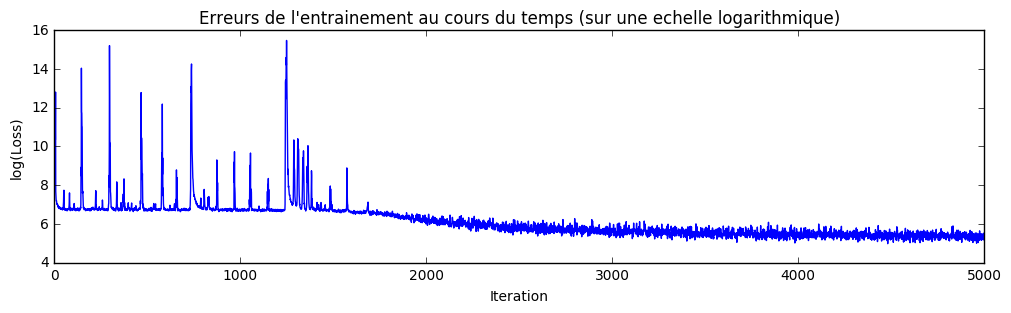

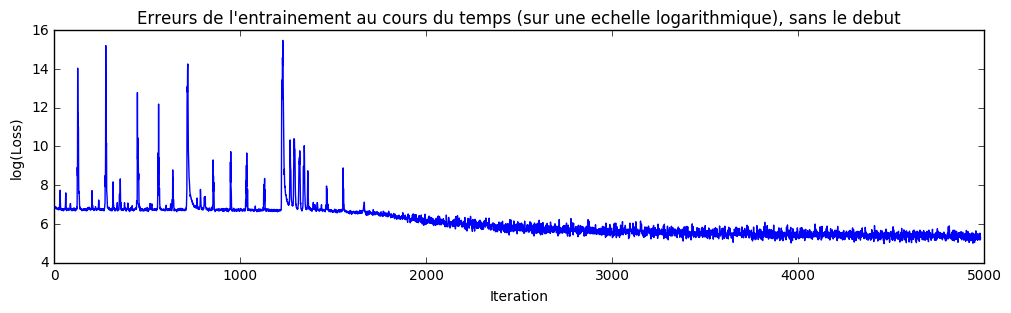

In [7]:
plt.figure(figsize=(12, 3))
plt.plot(np.log(train_losses), label="Loss")
plt.title("Erreurs de l'entrainement au cours du temps (sur une echelle logarithmique)")
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(np.log(train_losses[20:]), label="Loss")
plt.title("Erreurs de l'entrainement au cours du temps (sur une echelle logarithmique), sans le debut")
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.show()

Visualisons 5 prédictions quelconques avec nos signaux :


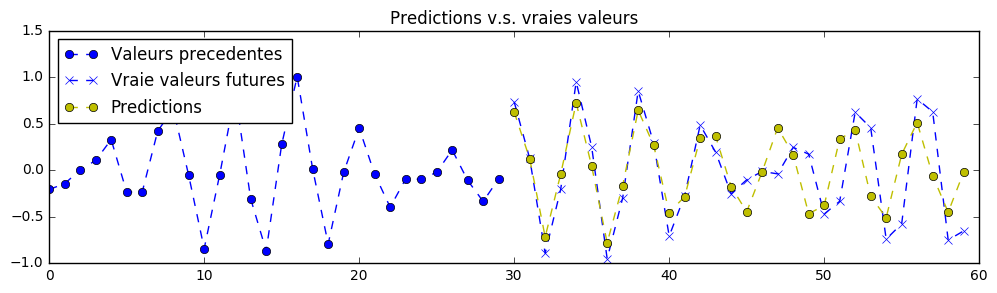

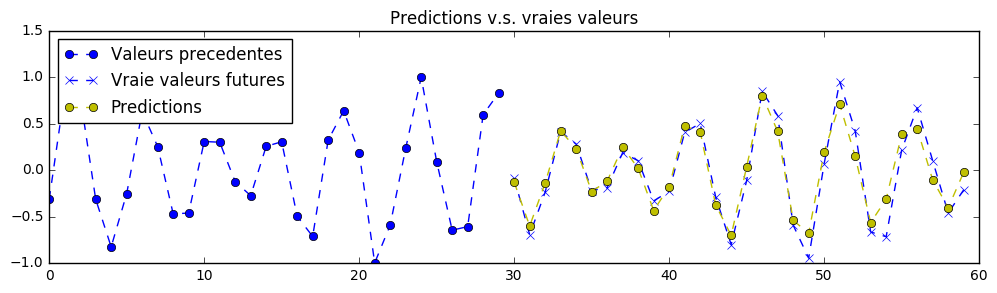

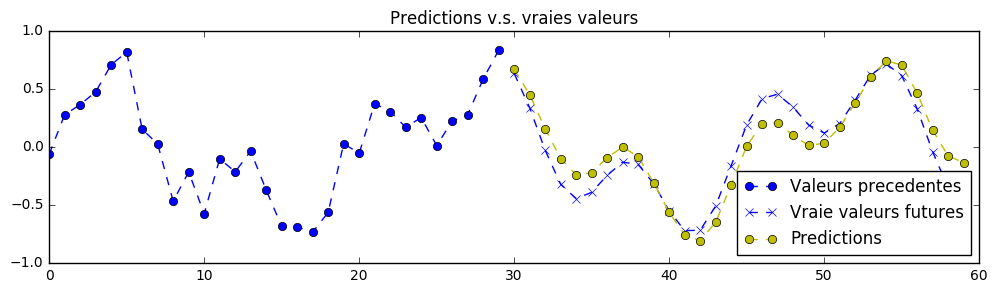

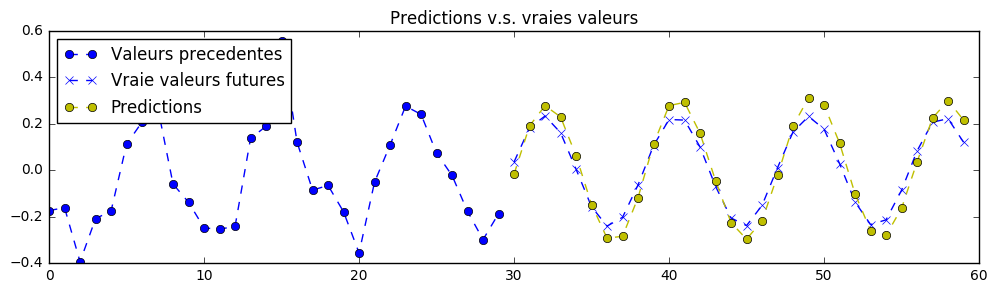

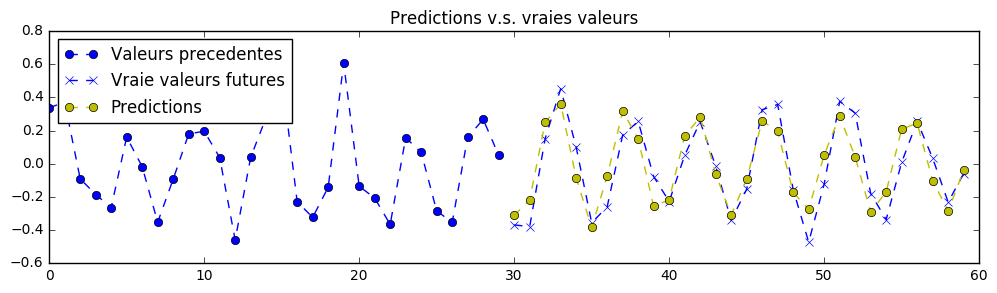

Le signal peut contenir plusieurs dimensions en sortie à la fois.
Si c'est le cas, les signaux sont empilés avec la même couleur.
En vrai, on pourrait imaginer plusieurs symboles boursiers évoluant dans le
même référentiel de temps, analysés en même temps par le même réseau de neurones.


In [8]:
# Tester
nb_predictions = 5
print "Visualisons {} prédictions quelconques avec nos signaux :".format(nb_predictions)

X, Y = generate_x_y_data(isTrain=True, batch_size=nb_predictions)
feed_dict = {enc_inp[t]: X[t] for t in range(seq_length)}
outputs = sess.run([reshaped_outputs], feed_dict)

for j in range(nb_predictions): 
    plt.figure(figsize=(12, 3))
    
    for k in range(output_dim):
        past = X[:,j,k]
        expected = Y[:,j,k]
        pred = np.array(outputs[0])[:,j,k]
        
        label1 = "Valeurs precedentes" if k==0 else "_nolegend_"
        label2 = "Vraie valeurs futures" if k==0 else "_nolegend_"
        label3 = "Predictions" if k==0 else "_nolegend_"
        plt.plot(range(len(past)), past, "o--b", label=label1)
        plt.plot(range(len(past), len(expected)+len(past)), expected, "x--b", label=label2)
        plt.plot(range(len(past), len(pred)+len(past)), pred, "o--y", label=label3)
    
    plt.legend(loc='best')
    plt.title("Predictions v.s. vraies valeurs")
    plt.show()

print "Le signal peut contenir plusieurs dimensions en sortie à la fois."
print "Si c'est le cas, les signaux sont empilés avec la même couleur."
print "En vrai, on pourrait imaginer plusieurs symboles boursiers évoluant dans le"
print "même référentiel de temps, analysés en même temps par le même réseau de neurones."